# Introducción

En este cuaderno utilizaremos el modelo Qwen2.5-Omni para analizar muestras de habla y transcripciones. Nuestro objetivo es identificar los siguientes rasgos:

- Identificar si se trata de un hablante nativo de inglés o no.
- Identificar si se trata de hombre o mujer.

Como partimos de un conjunto de datos etiquetados, llevaremos a cabo una evaluación para tomar métricas del desempeño del modelo.

Utilizaremos la librería outlines

# Instalamos las dependencias

In [ ]:
# El entorno de ejecución ya tiene instalado transformers de Huggingface
!pip install -U outlines transformers accelerate datasets[audio]

In [26]:
# Importamos los paquetes necesarios
from outlines.inputs import Image, Audio, Video
import outlines
from enum import Enum
from typing import Literal
from pydantic import BaseModel, constr, conint
import json
from datasets import load_dataset
import IPython.display as ipd
import soundfile as sf
from transformers import Qwen2_5OmniForConditionalGeneration, Qwen2_5OmniProcessor, Qwen2_5OmniThinkerForConditionalGeneration
import random
from pprint import pprint
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
random.seed(42)

# Exploramos un poco el dataset

Para llevar a cabo la clasificación de hablantes vamos a utilizar el dataset `edinburghcstr/edacc` que ya contiene etiquetas de la L1 de los hablantes. En un futuro me planteo utilizar el dataset `ylacombe/cml-tts` con ejemplos en español.

In [4]:
ds = load_dataset("edinburghcstr/edacc", split="validation")

README.md: 0.00B [00:00, ?B/s]

data/validation-00000-of-00006-17ec18f4d(…):   0%|          | 0.00/457M [00:00<?, ?B/s]

data/validation-00001-of-00006-6f3978e4f(…):   0%|          | 0.00/478M [00:00<?, ?B/s]

data/validation-00002-of-00006-5a1d86079(…):   0%|          | 0.00/446M [00:00<?, ?B/s]

data/validation-00003-of-00006-b26008b09(…):   0%|          | 0.00/492M [00:00<?, ?B/s]

data/validation-00004-of-00006-8cad96ca1(…):   0%|          | 0.00/787M [00:00<?, ?B/s]

data/validation-00005-of-00006-976f2f011(…):   0%|          | 0.00/676M [00:00<?, ?B/s]

data/test-00000-of-00010-f0aceb1ca4406ff(…):   0%|          | 0.00/471M [00:00<?, ?B/s]

data/test-00001-of-00010-856b016d9d438ff(…):   0%|          | 0.00/274M [00:00<?, ?B/s]

data/test-00002-of-00010-2b021baedb4deb8(…):   0%|          | 0.00/333M [00:00<?, ?B/s]

data/test-00003-of-00010-4de275e704375a0(…):   0%|          | 0.00/498M [00:00<?, ?B/s]

data/test-00004-of-00010-806407c9bc68112(…):   0%|          | 0.00/257M [00:00<?, ?B/s]

data/test-00005-of-00010-9c97c4c4c8d01f8(…):   0%|          | 0.00/282M [00:00<?, ?B/s]

data/test-00006-of-00010-cc4648d0f66f65a(…):   0%|          | 0.00/354M [00:00<?, ?B/s]

data/test-00007-of-00010-ea5ed4464ecff3c(…):   0%|          | 0.00/439M [00:00<?, ?B/s]

data/test-00008-of-00010-d1aa19b51ad423d(…):   0%|          | 0.00/409M [00:00<?, ?B/s]

data/test-00009-of-00010-648ce5002d12449(…):   0%|          | 0.00/299M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/9848 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9289 [00:00<?, ? examples/s]

In [5]:
sampled = random.sample(list(ds), 300)

In [6]:
def min_max_length(sample, min_sec:int=5, max_sec:int=15):
    return len(sample["audio"]["array"])/sample["audio"]["sampling_rate"] > min_sec and len(sample["audio"]["array"])/sample["audio"]["sampling_rate"] < max_sec

# Filtramos por longitud
sampled = [sample for sample in sampled if min_max_length(sample)]
print(len(sampled))

80


In [7]:
# Tomamos una muestra
sample = sampled[50]
audio_array = sample["audio"]["array"]
sampling_rate = sample["audio"]["sampling_rate"]
pprint(sample)
ipd.Audio(audio_array, rate=sampling_rate)


{'accent': 'Southern British English',
 'audio': <datasets.features._torchcodec.AudioDecoder object at 0x7cdfa4889d00>,
 'gender': 'female',
 'l1': 'Southern British English',
 'raw_accent': 'Southern London',
 'speaker': 'EDACC-C32-A',
 'text': "NO I DON'T THINK SO BUT IT WILL BE COOL TO LIKE FIND OUT OTHER "
         "PEOPLE'S EXPERIENCE YEAH"}


In [8]:
# Creamos las etiquetas
l1_lower = [sample['l1'].lower() for sample in sampled]
y_true = [1 if 'english' in sample else 0  for sample in l1_lower ]
assert len(y_true) == len(sampled), 'Hay un error con las longitudes de muestras y etiquetas'
print(f'Numero de hablantes nativos: {y_true.count(1)} - Número de hablantes no nativos: {y_true.count(0)}')

Numero de hablantes nativos: 27 - Número de hablantes no nativos: 53


In [9]:
# Hacemos un display de las posibles l1
set(l1_lower)

{'arabic',
 'bahasa',
 'bulgarian',
 'catalan',
 'dutch',
 'german',
 'indian english',
 'irish english',
 'italian',
 'mainstream us english',
 'maltese',
 'mandarin',
 'polish',
 'portoguese',
 'romanian',
 'russian',
 'scottish english',
 'south african english',
 'southern british english',
 'spanish',
 'vietnamese'}

# Definimos el esquema JSON

Nuestro objetivo es distinguir si se trata de un hablante nativo y si es hombre o mujer

In [10]:
# Definimos un tipo especial para la clase
class Gender(str, Enum):
    male = "male"
    female = "female"
# Creamos la estructura final
class AudioAnalysis(BaseModel):
    gender: Gender
    native: bool

In [11]:
# Definimos los prompts que usaremos más adelante
sistema = "You are Qwen, a virtual human developed by Alibaba Group, capable of perceiving auditory and visual inputs, as well as generating text and speech."
user_prompt = """I want you to analyze the speaker:
Your goal is to find if the speaker is a native spanish speaker or not. You also have to identify the speaker's gender.
Listen carefully and use this transcription to help you:
{transcript}"""

In [12]:
# Aquí guardaremos los resultados
results = []

# Cargamos el modelo

In [13]:
# default: Load the model on the available device(s)
hf_model = Qwen2_5OmniThinkerForConditionalGeneration.from_pretrained("Qwen/Qwen2.5-Omni-3B", dtype="half", device_map="auto")
hf_processor = Qwen2_5OmniProcessor.from_pretrained("Qwen/Qwen2.5-Omni-3B")
omni_model = outlines.from_transformers(hf_model, hf_processor)

config.json: 0.00B [00:00, ?B/s]

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/832 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

In [16]:
# Creamos un generador para poder compilar el autómata
generator = outlines.Generator(omni_model, AudioAnalysis)

# Realizamos el experimento

Iteramos en nuestras muestras para obtener los resultados

In [24]:
with tqdm(total=len(sampled)) as pbar:
  for sample, label in zip(sampled, y_true):
    # Construimos los inputs del modelo
    audio_array = sample["audio"]["array"]
    sampling_rate = sample["audio"]["sampling_rate"]
    transcript = sample['text']
    messages = outlines.inputs.Chat([
        {"role": "system", "content": sistema},
        {"role": "user", "content": [user_prompt.format(transcript=transcript), Audio(audio_array)]}
    ])
    result = generator(messages,
                       max_new_tokens=100,
                       do_sample=True)
    result = json.loads(result)
    result['label'] = label
    results.append(result)
    pbar.update(1)

100%|██████████| 80/80 [06:43<00:00,  5.04s/it]


# Evaluamos

Vamos a utilizar una matriz de confusión para visualizar los resultados de le preddicción `nativo`

In [27]:
ds = pd.DataFrame.from_records(results)
ds.head()

,gender,native,label
0,male,False,1
1,male,False,0
2,female,False,0
3,male,False,1
4,male,False,0


In [29]:
# Guardamos los datos
ds.to_csv('results.csv', index=False)

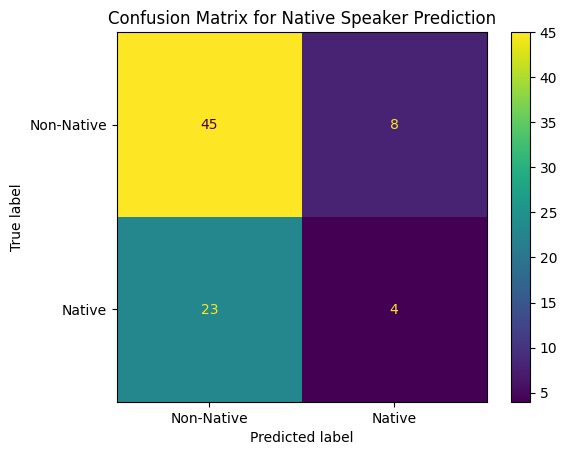

Classification Report:
              precision    recall  f1-score   support

  Non-Native       0.66      0.85      0.74        53
      Native       0.33      0.15      0.21        27

    accuracy                           0.61        80
   macro avg       0.50      0.50      0.47        80
weighted avg       0.55      0.61      0.56        80



In [28]:
# Extraemos las etiquetas y las predicciones (convertimos bool a int)
y_true = ds['label']
y_pred = ds['native'].astype(int)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
cmd = ConfusionMatrixDisplay(cm, display_labels=['Non-Native', 'Native'])
cmd.plot()
plt.title('Confusion Matrix for Native Speaker Prediction')
plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Non-Native', 'Native']))

# Conclusiones

Aunque los modelos multimodales sean prometedores todavía queda mucho por mejorar. No obstante, debemos tener en cuenta que se trata de una versión bastante pequeña (3B de parámetros) en un contexto de zero-shot.

Es posible que un ajuste de parámetros con un conjunto de datos multilingüe nos permita obtener mejores resultados.